# Drug Review Sentiment Classification

In this notebook, we aim to build an end-to-end machine learning and deep learning solution for **sentiment classification of drug reviews**.

We will:

- **Preprocess** free-text reviews using advanced text cleaning and lemmatization
- **Visualize** review patterns and sentiment distributions
- **Compare models** trained on **imbalanced** vs. **balanced** datasets
- Build both **Traditional ML** (TF-IDF) and **Deep Learning** (Bi-LSTM + CNN) classifiers
- **Evaluate and export** the best-performing models for deployment

---

### Dataset Description

We will be working with two datasets:
- `drugsComTrain_raw.csv` – training data (~161,000 reviews)
- `drugsComTest_raw.csv` – test data (~54,000 reviews)

Each row contains:

- **drugName**: Name of the medication  
- **condition**: Medical condition being treated  
- **review**: Free-text patient feedback  
- **rating**: Score from 1 (worst) to 10 (best)  
- **usefulCount**: Number of users who found it helpful  
- **date**: Submission date

---

### Goal

Our goal is to classify each review as one of:

- **Positive** (rating ≥ 7)
- **Neutral** (rating = 5 or 6)
- **Negative** (rating ≤ 4)

# STEP 1: Load and Combine Datasets

We begin by loading the two datasets provided:

- `drugsComTrain_raw.csv` - training data (~161K reviews)
- `drugsComTest_raw.csv` - test data (~54K reviews)

We will combine them into one unified dataset for consistent preprocessing, and remove rows missing key fields like review text, condition, or rating.

In [1]:
# Core Utilities
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib

# Text Processing & NLP
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from wordcloud import WordCloud

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, log_loss, classification_report, confusion_matrix
)

# Imbalanced Data Handling
from imblearn.over_sampling import SMOTE

# Deep Learning: TensorFlow / Keras
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import (
    Embedding, SpatialDropout1D, Bidirectional, LSTM, Conv1D,
    GlobalMaxPooling1D, Dense, Dropout
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# LightGBM
from lightgbm import LGBMClassifier

2025-05-15 20:30:58.990566: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-15 20:30:58.990917: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-15 20:30:58.995025: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-15 20:30:59.060129: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-15 20:31:00.275946: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [2]:
# Load training and test CSV files
train_df = pd.read_csv("../data/drugsComTrain_raw.csv")
test_df = pd.read_csv("../data/drugsComTest_raw.csv")

# Combine them into a single DataFrame
df = pd.concat([train_df, test_df], ignore_index=True)

# Drop rows with missing essential fields
df.dropna(subset=['review', 'rating', 'condition'], inplace=True)

# Preview dataset shape and sample rows
print(f"Combined dataset shape: {df.shape}")
df.head()

Combined dataset shape: (213869, 7)


,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


# STEP 2: Sentiment Mapping and Initial Distributions

Each review is rated on a scale from 1 to 10. We'll map these numerical ratings to sentiment labels:

- **Positive** → rating ≥ 7
- **Neutral** → rating = 5 or 6
- **Negative** → rating ≤ 4

Then we'll visualize:
- How ratings are distributed across the 1-10 scale
- The class distribution for our 3 sentiment labels


In [3]:
# Convert numeric rating into sentiment label
def map_sentiment(r):
    if r >= 7:
        return "positive"
    elif r <= 4:
        return "negative"
    else:
        return "neutral"

# Create a new sentiment column
df['sentiment'] = df['rating'].apply(map_sentiment)
df['sentiment'].value_counts()

sentiment
positive    141560
negative     53256
neutral      19053
Name: count, dtype: int64

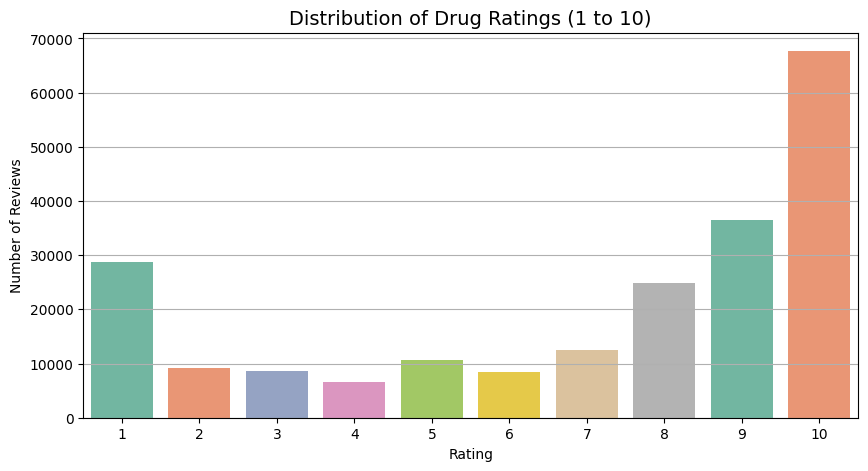

In [4]:
# Plot full rating scale
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='rating', hue='rating', palette='Set2', legend=False)
plt.title("Distribution of Drug Ratings (1 to 10)", fontsize=14)
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")
plt.grid(axis='y')
plt.show()

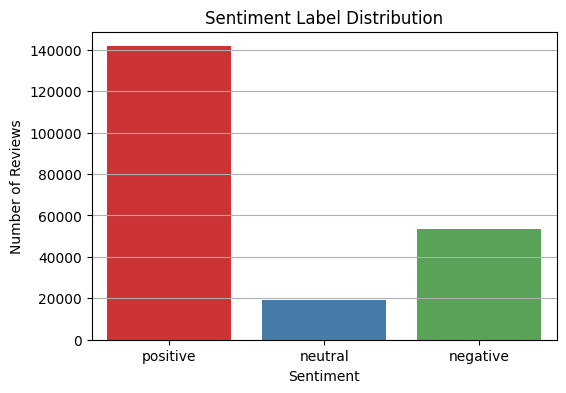

In [5]:
# Plot sentiment class distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='sentiment', order=['positive', 'neutral', 'negative'], palette='Set1', hue='sentiment', legend=False)
plt.title("Sentiment Label Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.grid(axis='y')
plt.show()

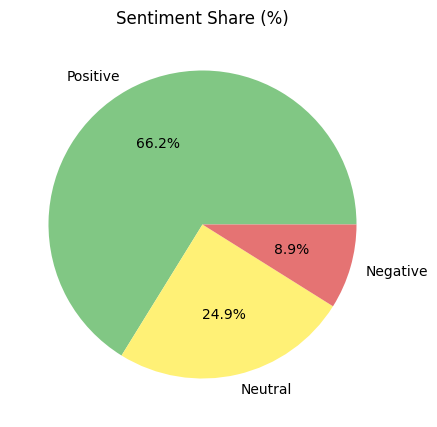

In [6]:
# Pie chart of sentiment distribution
df['sentiment'].value_counts(normalize=True).plot.pie(
    labels=['Positive', 'Neutral', 'Negative'],
    autopct='%1.1f%%',
    colors=['#81c784', '#fff176', '#e57373'],
    figsize=(5, 5)
)
plt.title("Sentiment Share (%)")
plt.ylabel("")
plt.show()

# STEP 3: Rich Exploratory Data Analysis

Before diving into modeling, let's explore our data more deeply.

We'll cover:

- Top drugs and conditions
- Review structure (word counts, average word length)
- Whether the review mentions the drug name
- Word clouds for each sentiment
- Most frequent unigrams and bigrams


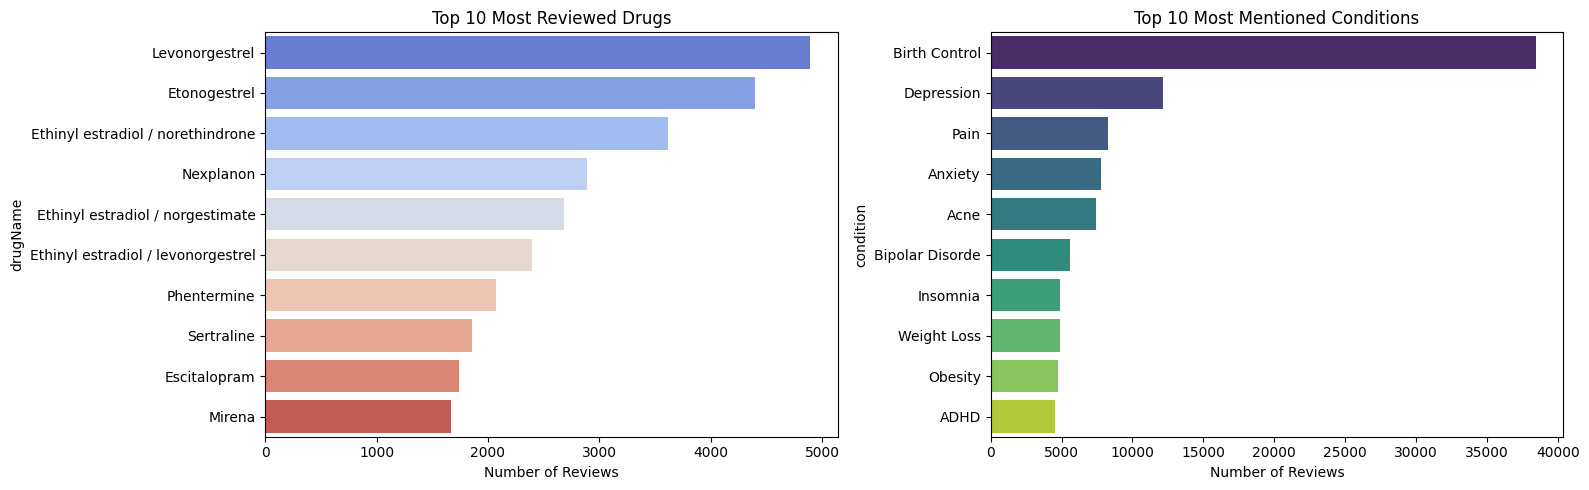

In [7]:
# Top 10 most reviewed drugs and conditions
top_drugs = df['drugName'].value_counts().head(10)
top_conditions = df['condition'].value_counts().head(10)

# Plot top drugs and conditions
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.barplot(y=top_drugs.index, x=top_drugs.values, ax=axes[0], palette='coolwarm', hue=top_drugs.index, legend=False)
axes[0].set_title("Top 10 Most Reviewed Drugs")
axes[0].set_xlabel("Number of Reviews")

sns.barplot(y=top_conditions.index, x=top_conditions.values, ax=axes[1], palette='viridis', hue=top_conditions.index, legend=False)
axes[1].set_title("Top 10 Most Mentioned Conditions")
axes[1].set_xlabel("Number of Reviews")

plt.tight_layout()
plt.show()

In [8]:
# Review structure features
df['review_length'] = df['review'].apply(lambda x: len(str(x).split()))
df['char_count'] = df['review'].apply(lambda x: len(str(x)))
df['avg_word_len'] = df['char_count'] / df['review_length']

# Flag: does the review mention the drug name?
df['has_drug_name'] = df.apply(
    lambda row: 1 if str(row['drugName']).lower() in str(row['review']).lower() else 0,
    axis=1
)

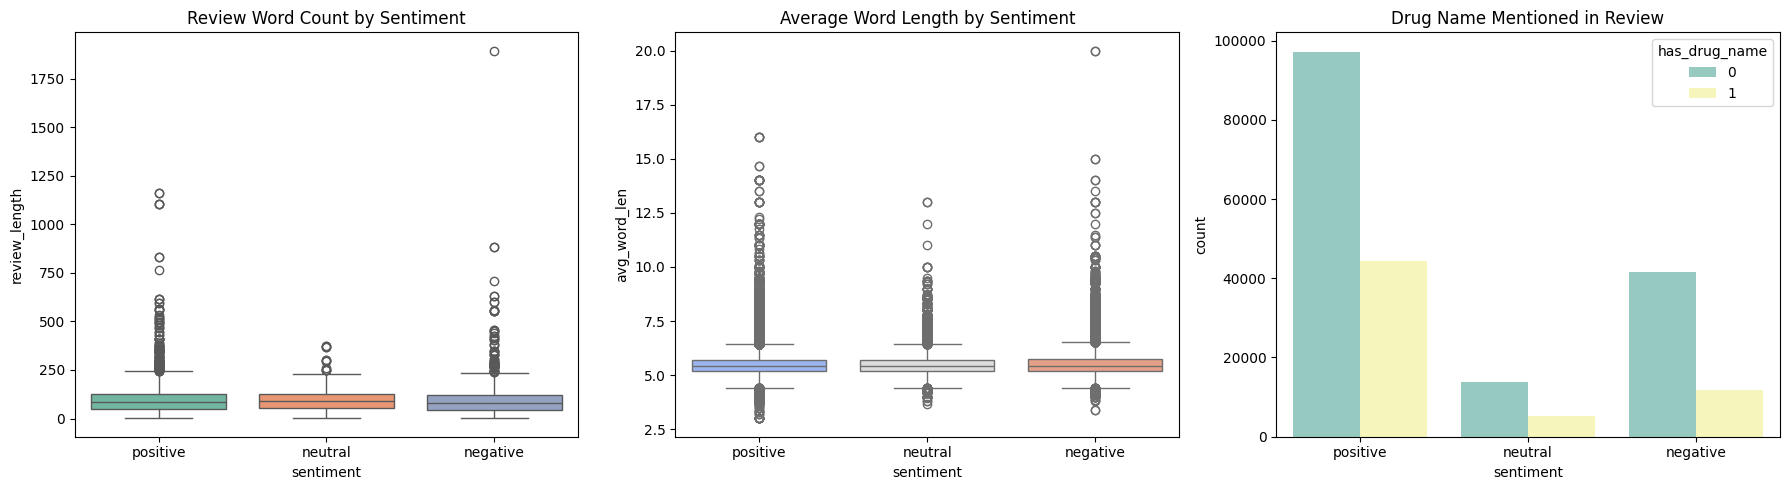

In [9]:
# Plot structural feature distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(data=df, x='sentiment', y='review_length', ax=axes[0], palette='Set2', hue='sentiment', legend=False)
axes[0].set_title("Review Word Count by Sentiment")

sns.boxplot(data=df, x='sentiment', y='avg_word_len', ax=axes[1], palette='coolwarm', hue='sentiment', legend=False)
axes[1].set_title("Average Word Length by Sentiment")

sns.countplot(data=df, x='sentiment', hue='has_drug_name', palette='Set3', ax=axes[2])
axes[2].set_title("Drug Name Mentioned in Review")

plt.tight_layout()
plt.show()

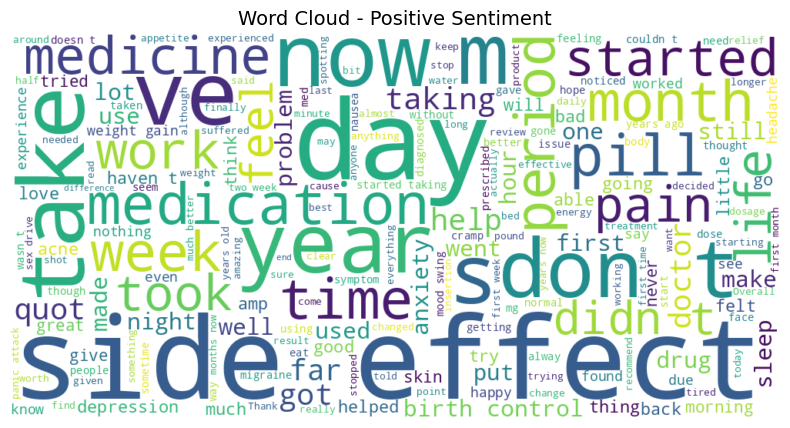

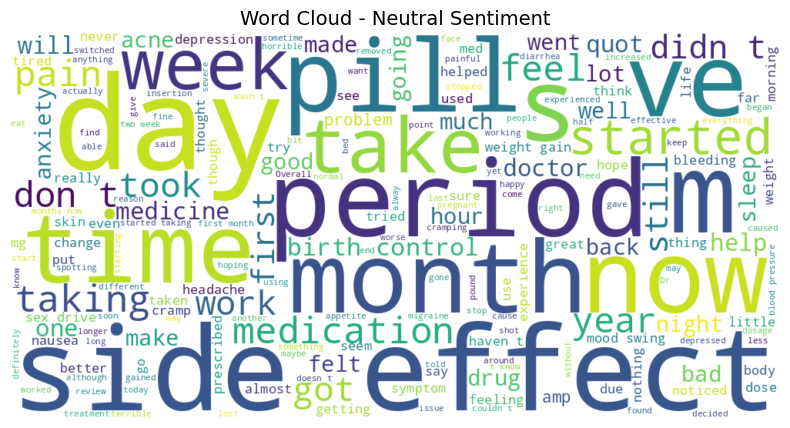

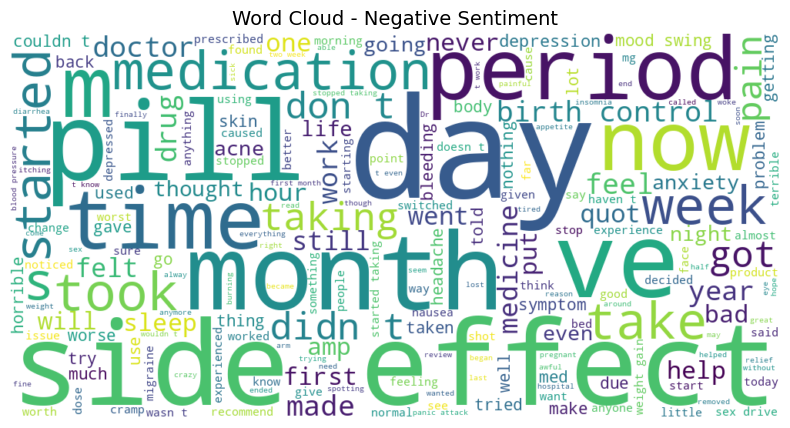

In [10]:
# Generate a word cloud per sentiment
for label in ['positive', 'neutral', 'negative']:
    text = " ".join(df[df['sentiment'] == label]['review'].astype(str))
    wc = WordCloud(width=1000, height=500, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud - {label.capitalize()} Sentiment", fontsize=14)
    plt.show()

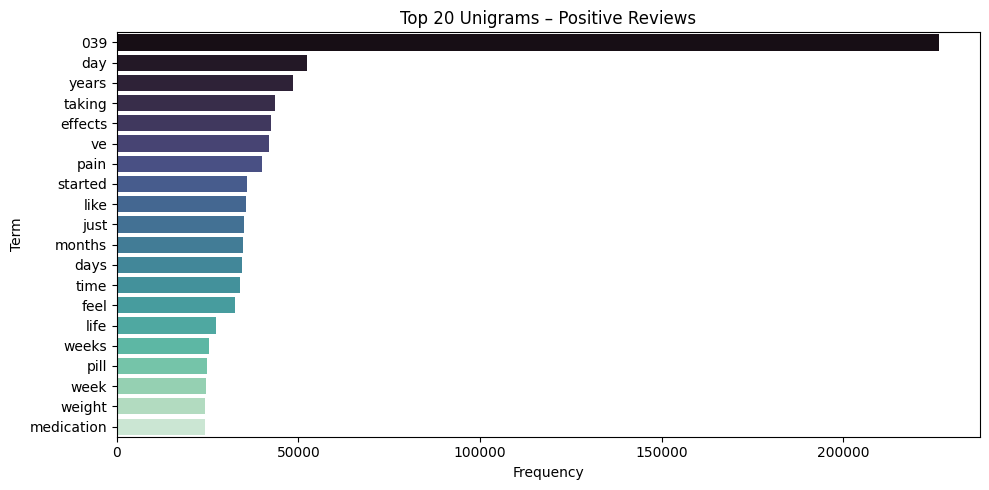

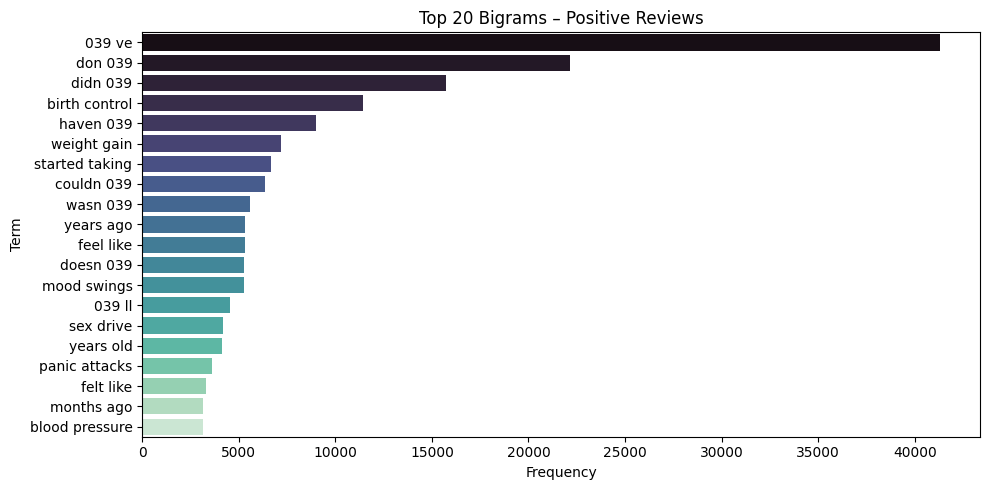

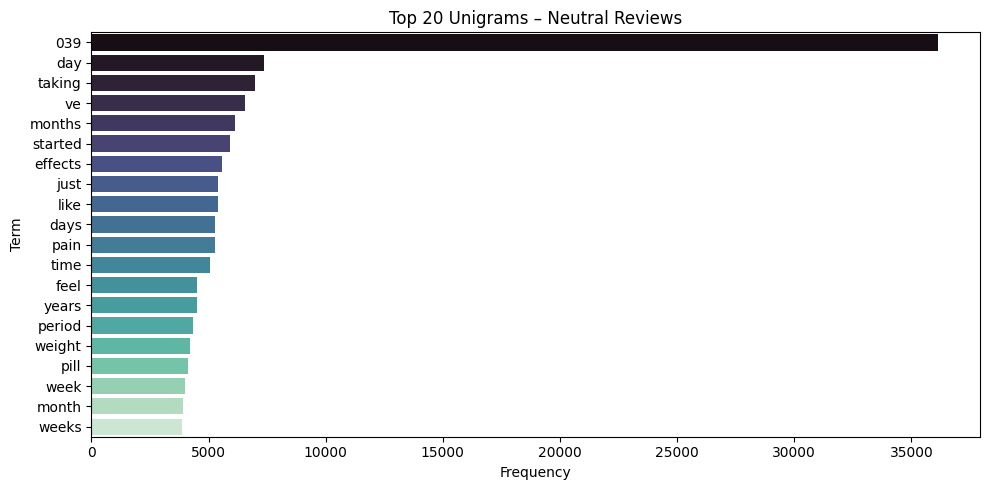

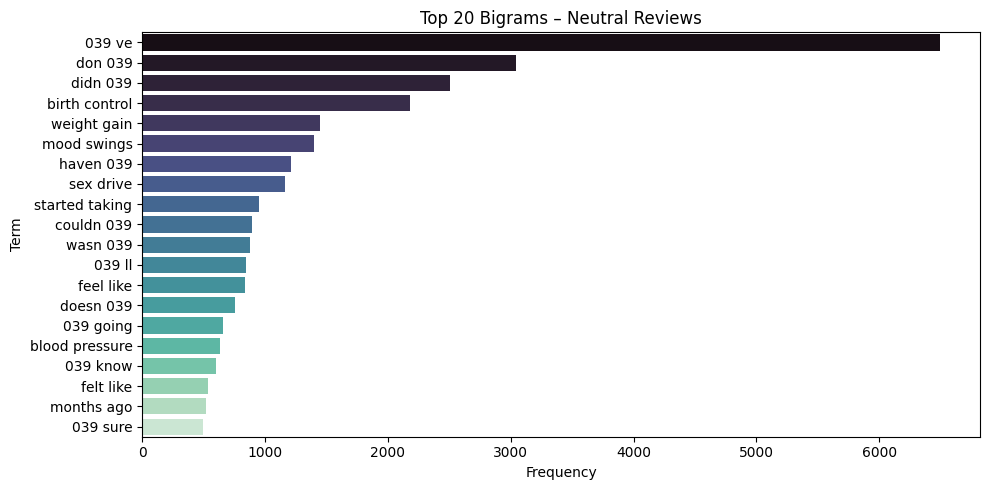

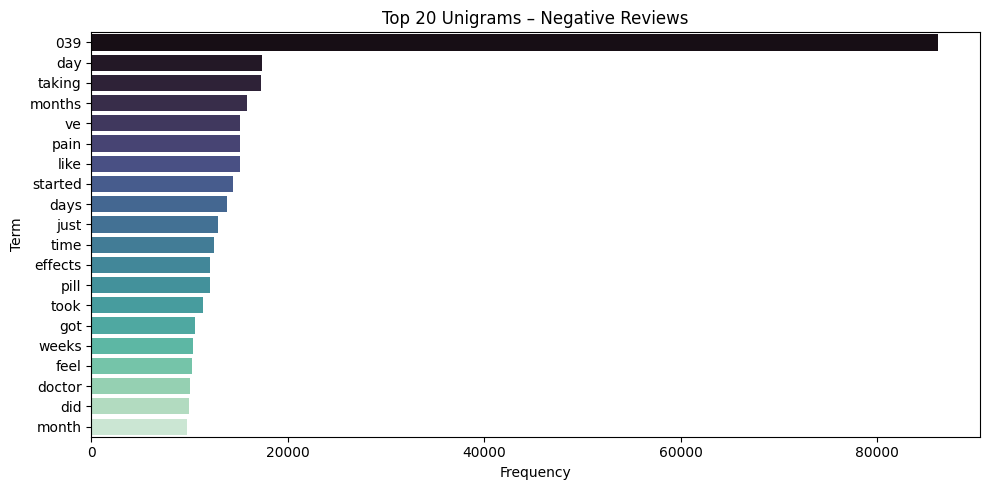

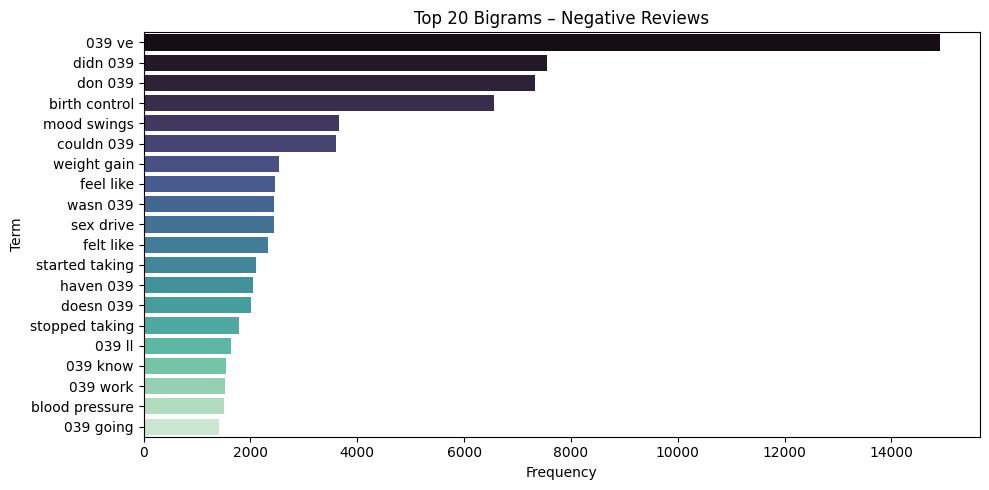

In [11]:
def plot_ngrams_by_sentiment(sentiment, ngram_range=(1,1), top_n=20):
    subset = df[df['sentiment'] == sentiment]['review'].astype(str)
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vec.fit_transform(subset)
    freqs = zip(vec.get_feature_names_out(), X.sum(axis=0).tolist()[0])
    sorted_freqs = sorted(freqs, key=lambda x: x[1], reverse=True)[:top_n]
    labels, values = zip(*sorted_freqs)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=values, y=labels, palette='mako', hue=labels, legend=False)
    title = "Unigrams" if ngram_range == (1,1) else "Bigrams"
    plt.title(f"Top {top_n} {title} – {sentiment.capitalize()} Reviews")
    plt.xlabel("Frequency")
    plt.ylabel("Term")
    plt.tight_layout()
    plt.show()

# Run for all 3 sentiments
for sentiment in ['positive', 'neutral', 'negative']:
    plot_ngrams_by_sentiment(sentiment, ngram_range=(1,1))
    plot_ngrams_by_sentiment(sentiment, ngram_range=(2,2))

# STEP 4: Text Preprocessing - Cleaning and Lemmatization

Now we'll clean the review text before feeding it into our models.

The cleaning pipeline includes:
- Lowercasing
- Removing punctuation, digits, and extra spaces
- Removing stopwords
- Lemmatizing each word using POS tagging (e.g., run → running)

This results in a new column: `clean_review`


In [12]:
# Download NLTK resources (only once)
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger")
nltk.download("omw-1.4")
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

# Set up preprocessing tools
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# POS tag → WordNet mapping
def get_wordnet_pos(tag):
    if tag.startswith('J'): return wordnet.ADJ
    elif tag.startswith('V'): return wordnet.VERB
    elif tag.startswith('N'): return wordnet.NOUN
    elif tag.startswith('R'): return wordnet.ADV
    return wordnet.NOUN

# Main preprocessing function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', ' ', text)              # Remove HTML
    text = re.sub(r'[^a-z\s]', '', text)            # Keep only letters
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    tagged = pos_tag(tokens)
    lemmatized = [lemmatizer.lemmatize(w, get_wordnet_pos(t)) for w, t in tagged]
    return " ".join(lemmatized)

[nltk_data] Downloading package punkt to /home/rasagna/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rasagna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/rasagna/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/rasagna/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /home/rasagna/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/rasagna/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/rasagna/nltk_data...
[nltk_data]   Package averaged_perceptron_ta

In [13]:
# Apply cleaning to all reviews
df['clean_review'] = df['review'].astype(str).apply(clean_text)

# Preview a few examples
df[['review', 'clean_review', 'sentiment']].sample(5)

,review,clean_review,sentiment
6899,"""I am 26 years old. Never had acne problems, e...",year old never acne problem even teenage start...,positive
89987,"""I have been taking it for many years now for ...",take many year tonic clonic epilepsy well yrs ...,neutral
194683,"""A few weeks ago my physician gave me a sample...",week ago physician give sample try since syymi...,positive
172761,"""It has been a great medicine to help with my ...",great medicine help anxiety feel much calm con...,positive
9667,"""I know it&#039;s hard not freaking out, but g...",know hard freak guy try calm wait effect pill ...,positive


# STEP 5: Feature Engineering - TF-IDF and Token Sequences

To train machine learning and deep learning models, we must convert our cleaned text into numerical features.

We will create:
- **TF-IDF vectors** for traditional ML models
- **Padded sequences** for deep learning (via Keras tokenizer)
- **Encoded labels** using LabelEncoder


In [14]:
# Set base variables
X_text = df['clean_review']
y_text = df['sentiment']

# Label encode sentiment
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_text)

# Train-test split (stratified)
X_train_txt, X_test_txt, y_train_enc, y_test_enc = train_test_split(
    X_text, y_encoded, stratify=y_encoded, test_size=0.2, random_state=42
)

In [15]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_txt)
X_test_tfidf = tfidf_vectorizer.transform(X_test_txt)

In [16]:
# Tokenizer for DL models
vocab_size = 15000
max_len = 100
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_txt)

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train_txt), maxlen=max_len, padding='post')
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test_txt), maxlen=max_len, padding='post')

# STEP 6: ML Models - Imbalanced Dataset (TF-IDF Features)

We'll first train traditional ML models using the **original (imbalanced)** data:

- Logistic Regression
- Random Forest
- Linear SVC
- LightGBM

All models will be trained on **TF-IDF features**.
We'll later compare their performance against balanced versions (SMOTE).


In [17]:
# Initialize models
models_imbal = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Linear SVC": LinearSVC(),
    "LightGBM": LGBMClassifier(random_state=42)
}

# Train and store models
trained_imbal = {}

for name, model in models_imbal.items():
    model.fit(X_train_tfidf, y_train_enc)
    trained_imbal[name] = model
    print(f"Trained: {name}")

Trained: Logistic Regression
Trained: Random Forest


/home/rasagna/Desktop/Rasagna/Birmingham City University - AI Engineer/Drug_Reviews_Sentiment_Analysis/.venv/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Trained: Linear SVC
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.697712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1015760
[LightGBM] [Info] Number of data points in the train set: 171095, number of used features: 10000
[LightGBM] [Info] Start training from score -1.390247
[LightGBM] [Info] Start training from score -2.418164
[LightGBM] [Info] Start training from score -0.412639
Trained: LightGBM


# STEP 7: ML Models - SMOTE Balanced Dataset

We now address class imbalance using **SMOTE (Synthetic Minority Oversampling Technique)**.

This technique creates synthetic examples of the minority classes so all sentiment classes have roughly equal representation.

We'll:
- Apply SMOTE to the training TF-IDF matrix
- Retrain the same 4 traditional ML models
- Compare their results to the imbalanced versions


In [18]:
# Apply SMOTE to training set
smote = SMOTE(random_state=42)
X_train_tfidf_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train_enc)

print("After SMOTE:", dict(pd.Series(y_train_smote).value_counts()))

# Reinitialize and retrain models on balanced data
models_bal = {
    "Logistic Regression (SMOTE)": LogisticRegression(max_iter=1000),
    "Random Forest (SMOTE)": RandomForestClassifier(n_estimators=100, random_state=42),
    "Linear SVC (SMOTE)": LinearSVC(),
    "LightGBM (SMOTE)": LGBMClassifier(random_state=42)
}

trained_bal = {}

for name, model in models_bal.items():
    model.fit(X_train_tfidf_smote, y_train_smote)
    trained_bal[name] = model
    print(f"Trained on balanced data: {name}")

After SMOTE: {2: 113248, 0: 113248, 1: 113248}
Trained on balanced data: Logistic Regression (SMOTE)
Trained on balanced data: Random Forest (SMOTE)


/home/rasagna/Desktop/Rasagna/Birmingham City University - AI Engineer/Drug_Reviews_Sentiment_Analysis/.venv/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Trained on balanced data: Linear SVC (SMOTE)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 5.059549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1162671
[LightGBM] [Info] Number of data points in the train set: 339744, number of used features: 10000
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Trained on balanced data: LightGBM (SMOTE)


# STEP 8: Deep Learning Model - Imbalanced Dataset

We'll now build a deep learning model using:

- Bi-LSTM to capture sequence dependencies
- 1D CNN to extract local text patterns
- Pre-trained GloVe embeddings (300D)
- No class weights yet (this uses imbalanced data)

This model will later be compared to the balanced version using class weights.

In [19]:
embedding_dim = 300
embedding_index = {}

# Load GloVe vectors
with open("../data/glove.6B.300d.txt", encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

# Create embedding matrix
word_index = tokenizer.word_index
vocab_size = min(15000, len(word_index) + 1)
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, idx in word_index.items():
    if idx < vocab_size:
        vec = embedding_index.get(word)
        if vec is not None:
            embedding_matrix[idx] = vec

In [20]:
# One-hot encode labels for softmax output
y_train_cat = to_categorical(y_train_enc, num_classes=3)
y_test_cat = to_categorical(y_test_enc, num_classes=3)

# Build model
model_imbal = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
              input_length=100, trainable=False),
    SpatialDropout1D(0.3),
    Bidirectional(LSTM(128, return_sequences=True)),
    Conv1D(64, 3, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model_imbal.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history_imbal = model_imbal.fit(
    X_train_seq, y_train_cat,
    validation_data=(X_test_seq, y_test_cat),
    epochs=10,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

/home/rasagna/Desktop/Rasagna/Birmingham City University - AI Engineer/Drug_Reviews_Sentiment_Analysis/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
2674/2674 ━━━━━━━━━━━━━━━━━━━━ 370s 137ms/step - accuracy: 0.7136 - loss: 0.7203 - val_accuracy: 0.7790 - val_loss: 0.5684
Epoch 2/10
2674/2674 ━━━━━━━━━━━━━━━━━━━━ 362s 135ms/step - accuracy: 0.7805 - loss: 0.5740 - val_accuracy: 0.8011 - val_loss: 0.5193
Epoch 3/10
2674/2674 ━━━━━━━━━━━━━━━━━━━━ 372s 139ms/step - accuracy: 0.8032 - loss: 0.5199 - val_accuracy: 0.8107 - val_loss: 0.4948
Epoch 4/10
2674/2674 ━━━━━━━━━━━━━━━━━━━━ 379s 142ms/step - accuracy: 0.8150 - loss: 0.4877 - val_accuracy: 0.8163 - val_loss: 0.4767
Epoch 5/10
2674/2674 ━━━━━━━━━━━━━━━━━━━━ 364s 136ms/step - accuracy: 0.8284 - loss: 0.4512 - val_accuracy: 0.8243 - val_loss: 0.4620
Epoch 6/10
2674/2674 ━━━━━━━━━━━━━━━━━━━━ 353s 132ms/step - accuracy: 0.8371 - loss: 0.4248 - val_accuracy: 0.8292 - val_loss: 0.4482
Epoch 7/10
2674/2674 ━━━━━━━━━━━━━━━━━━━━ 333s 125ms/step - accuracy: 0.8441 - loss: 0.4019 - val_accuracy: 0.8342 - val_loss: 0.4446
Epoch 8/10
2674/2674 ━━━━━━━━━━━━━━━━━━━━ 338s 126ms/step - ac

# STEP 9: Deep Learning Model - Balanced with Class Weights

To improve performance on minority sentiment classes, we'll train the same Bi-LSTM + CNN model using **class weights**.

Class weights assign higher penalty to underrepresented classes during training. This helps the model treat all classes more equally.


In [21]:
# Compute class weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_enc),
    y=y_train_enc
)

class_weights_dict = dict(enumerate(class_weights_array))
print("Class Weights:", class_weights_dict)

Class Weights: {0: 1.3386144036302468, 1: 3.7417443030223505, 2: 0.5035997692380145}


In [22]:
# Clone the previous model architecture
model_bal = clone_model(model_imbal)
model_bal.set_weights(model_imbal.get_weights())  # Optional: transfer pre-trained weights
model_bal.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train using class weights
history_bal = model_bal.fit(
    X_train_seq, y_train_cat,
    validation_data=(X_test_seq, y_test_cat),
    epochs=10,
    batch_size=64,
    callbacks=[early_stop],
    class_weight=class_weights_dict,
    verbose=1
)

Epoch 1/10
2674/2674 ━━━━━━━━━━━━━━━━━━━━ 342s 127ms/step - accuracy: 0.8046 - loss: 0.5640 - val_accuracy: 0.7496 - val_loss: 0.5729
Epoch 2/10
2674/2674 ━━━━━━━━━━━━━━━━━━━━ 365s 136ms/step - accuracy: 0.8012 - loss: 0.5298 - val_accuracy: 0.7822 - val_loss: 0.5217


# STEP 10: Evaluate All Models  Imbalanced vs Balanced

We'll now evaluate:
- 4 traditional ML models (imbalanced & SMOTE-balanced)
- 2 Bi-LSTM+CNN models (imbalanced & class-weight-balanced)

Each will be assessed using:
- Accuracy
- Precision / Recall
- F1-score (macro, micro, weighted)
- Confusion Matrix
- ROC-AUC (macro)
- Log Loss


In [23]:
def evaluate_model(name, y_true, y_pred, y_prob=None):
    print(f"{name} — Evaluation Report")
    print("-" * 60)

    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")

    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Metrics summary
    metrics = {
        'Model': name,
        'Accuracy': acc,
        'F1 (Macro)': f1_score(y_true, y_pred, average='macro'),
        'F1 (Micro)': f1_score(y_true, y_pred, average='micro'),
        'F1 (Weighted)': f1_score(y_true, y_pred, average='weighted'),
        'Precision (Macro)': precision_score(y_true, y_pred, average='macro'),
        'Recall (Macro)': recall_score(y_true, y_pred, average='macro')
    }

    # Add ROC-AUC and log loss if probs provided
    if y_prob is not None:
        try:
            metrics['ROC-AUC (Macro)'] = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
            metrics['Log Loss'] = log_loss(y_true, y_prob)
        except:
            metrics['ROC-AUC (Macro)'] = 'N/A'
            metrics['Log Loss'] = 'N/A'

    return metrics

In [24]:
def evaluate_model(name, y_true, y_pred, y_prob=None):
    return {
        'Model': name,
        'Accuracy': round(accuracy_score(y_true, y_pred), 4),
        'F1 (Macro)': round(f1_score(y_true, y_pred, average='macro'), 4),
        'F1 (Micro)': round(f1_score(y_true, y_pred, average='micro'), 4),
        'F1 (Weighted)': round(f1_score(y_true, y_pred, average='weighted'), 4),
        'Precision (Macro)': round(precision_score(y_true, y_pred, average='macro'), 4),
        'Recall (Macro)': round(recall_score(y_true, y_pred, average='macro'), 4),
        'ROC-AUC (Macro)': round(roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro'), 4)
            if y_prob is not None else 'N/A',
        'Log Loss': round(log_loss(y_true, y_prob), 4) if y_prob is not None else 'N/A'
    }

In [25]:
results = []

# Traditional ML - Imbalanced
for name, model in trained_imbal.items():
    preds = model.predict(X_test_tfidf)
    probas = model.predict_proba(X_test_tfidf) if hasattr(model, "predict_proba") else None
    results.append(evaluate_model(f"{name} (Imbalanced)", y_test_enc, preds, probas))

# Traditional ML - Balanced (SMOTE)
for name, model in trained_bal.items():
    preds = model.predict(X_test_tfidf)
    probas = model.predict_proba(X_test_tfidf) if hasattr(model, "predict_proba") else None
    results.append(evaluate_model(name, y_test_enc, preds, probas))

# Deep Learning - Imbalanced
y_pred_prob_imbal = model_imbal.predict(X_test_seq)
y_pred_imbal = np.argmax(y_pred_prob_imbal, axis=1)
results.append(evaluate_model("Bi-LSTM + CNN (Imbalanced)", y_test_enc, y_pred_imbal, y_pred_prob_imbal))

# Deep Learning - Balanced
y_pred_prob_bal = model_bal.predict(X_test_seq)
y_pred_bal = np.argmax(y_pred_prob_bal, axis=1)
results.append(evaluate_model("Bi-LSTM + CNN (Class Weights)", y_test_enc, y_pred_bal, y_pred_prob_bal))

# Final comparison table
eval_df = pd.DataFrame(results)
eval_df = eval_df.sort_values(by="F1 (Macro)", ascending=False)
eval_df.reset_index(drop=True, inplace=True)
eval_df

1337/1337 ━━━━━━━━━━━━━━━━━━━━ 45s 33ms/step
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 46s 34ms/step


,Model,Accuracy,F1 (Macro),F1 (Micro),F1 (Weighted),Precision (Macro),Recall (Macro),ROC-AUC (Macro),Log Loss
0,Random Forest (Imbalanced),0.9041,0.8519,0.9041,0.8995,0.9434,0.7966,0.9634,0.3514
1,Random Forest (SMOTE),0.9008,0.8481,0.9008,0.8967,0.9239,0.8001,0.9638,0.3608
2,Bi-LSTM + CNN (Class Weights),0.7496,0.6617,0.7496,0.7900,0.6853,0.7325,0.9133,0.5729
3,Bi-LSTM + CNN (Imbalanced),0.8417,0.6164,0.8417,0.8168,0.6789,0.6265,0.9115,0.4283
4,Logistic Regression (SMOTE),0.7409,0.6160,0.7409,0.7579,0.6096,0.6404,0.8495,0.6387
5,Linear SVC (SMOTE),0.7410,0.6152,0.7410,0.7573,0.6079,0.6392,N/A,N/A
6,Linear SVC (Imbalanced),0.7980,0.5730,0.7980,0.7706,0.6602,0.5714,N/A,N/A
7,Logistic Regression (Imbalanced),0.7984,0.5708,0.7984,0.7700,0.6569,0.5679,0.8678,0.5213
8,LightGBM (SMOTE),0.7329,0.5672,0.7329,0.7317,0.5677,0.5668,0.8184,0.6876
9,LightGBM (Imbalanced),0.7724,0.5107,0.7724,0.7307,0.7430,0.5126,0.8454,0.5851


/tmp/ipykernel_8460/3785650175.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=eval_df, palette='Set2')


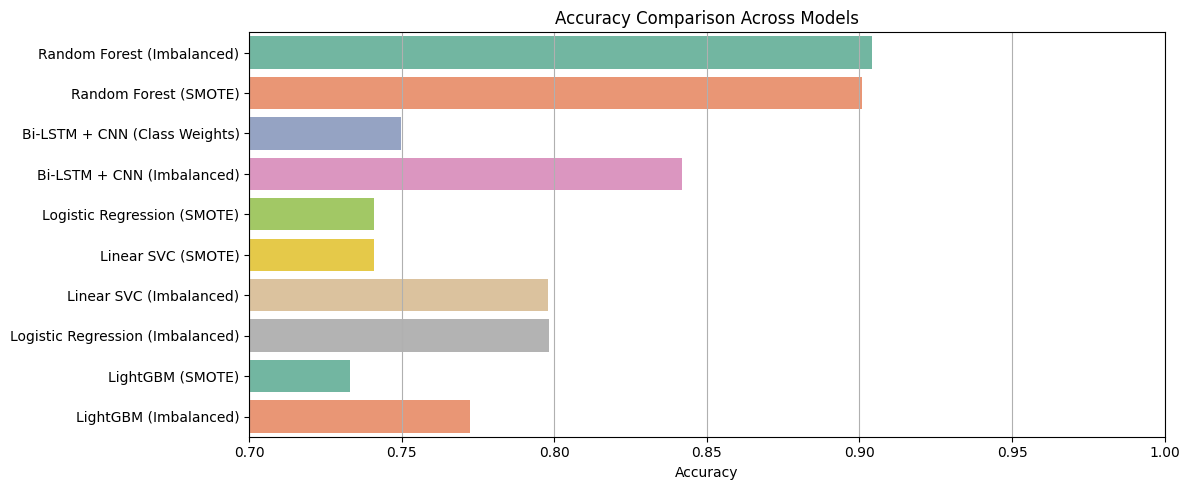

/tmp/ipykernel_8460/3785650175.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F1 (Macro)', y='Model', data=eval_df, palette='coolwarm')


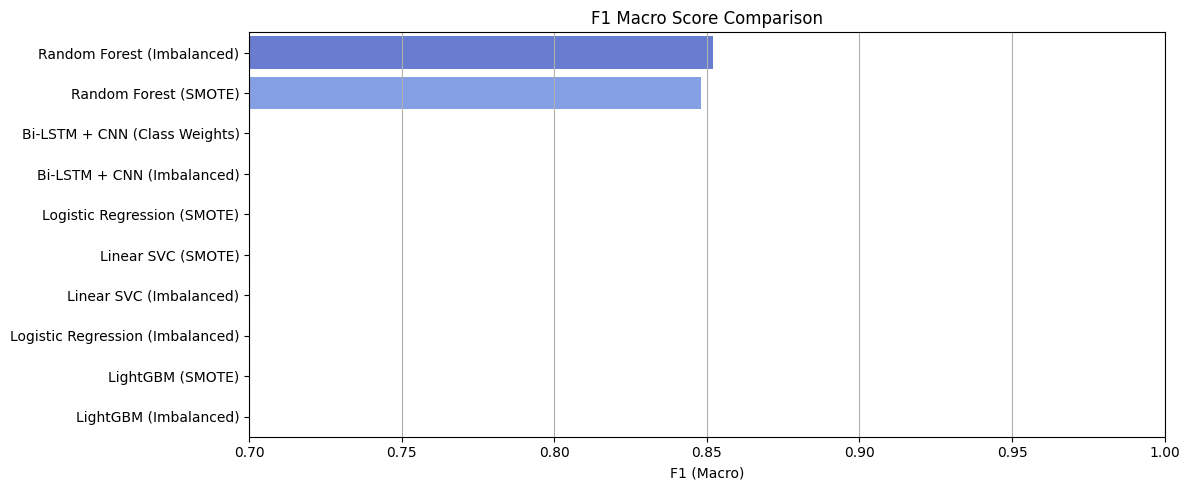

In [26]:
# Plot Accuracy
plt.figure(figsize=(12, 5))
sns.barplot(x='Accuracy', y='Model', data=eval_df, palette='Set2')
plt.title("Accuracy Comparison Across Models")
plt.xlim(0.7, 1.0)
plt.xlabel("Accuracy")
plt.ylabel("")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# Plot F1 (Macro)
plt.figure(figsize=(12, 5))
sns.barplot(x='F1 (Macro)', y='Model', data=eval_df, palette='coolwarm')
plt.title("F1 Macro Score Comparison")
plt.xlim(0.7, 1.0)
plt.xlabel("F1 (Macro)")
plt.ylabel("")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# STEP 11: Save All Models and Feature Processors

To prepare for deployment, we’ll save:
- Traditional ML models (4 imbalanced + 4 SMOTE balanced)
- Deep learning models (Bi-LSTM + CNN – both imbalanced and class-weighted)
- Feature processors:
  - `TF-IDF Vectorizer` for ML
  - `Tokenizer` for DL
  - `LabelEncoder` for inverse mapping

In [28]:
# Ensure the 'models' folder exists
os.makedirs("../models", exist_ok=True)

# Save imbalanced ML models
joblib.dump(trained_imbal['Logistic Regression'], "../models/logistic_regression_model_imbal.pkl")
joblib.dump(trained_imbal['Random Forest'], "../models/random_forest_model_imbal.pkl")
joblib.dump(trained_imbal['Linear SVC'], "../models/linear_svc_model_imbal.pkl")
joblib.dump(trained_imbal['LightGBM'], "../models/lightgbm_model_imbal.pkl")

# Save SMOTE-balanced ML models
joblib.dump(trained_bal['Logistic Regression (SMOTE)'], "../models/logistic_regression_model_bal.pkl")
joblib.dump(trained_bal['Random Forest (SMOTE)'], "../models/random_forest_model_bal.pkl")
joblib.dump(trained_bal['Linear SVC (SMOTE)'], "../models/linear_svc_model_bal.pkl")
joblib.dump(trained_bal['LightGBM (SMOTE)'], "../models/lightgbm_model_bal.pkl")

# Save feature processors
joblib.dump(tfidf_vectorizer, "../models/tfidf_vectorizer.pkl")
joblib.dump(label_encoder, "../models/label_encoder.pkl")

with open("../models/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Save Deep Learning models
model_imbal.save("../models/bilstm_cnn_model_imbalanced.h5")
model_bal.save("../models/bilstm_cnn_model_balanced.h5")

print("All models and components saved in the 'models' directory.")

All models and components saved in the 'models' directory.
